In [1]:
#from memory_profiler import profile
#%load_ext memory_profiler

import os, copy
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from transformers import BertJapaneseTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, EvalPrediction, get_linear_schedule_with_warmup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

model_name = "cl-tohoku/bert-base-japanese-v3"
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

# データの読み込みと前処理
def load_data(directory):
    texts, labels = [], []
    for label, category in enumerate(["dokujo-tsushin", "it-life-hack"]):
        category_dir = os.path.join(directory, category)
        for file in os.listdir(category_dir):
            if os.path.isfile(os.path.join(category_dir, file)):
                with open(os.path.join(category_dir, file), 'r', encoding='utf-8') as f:
                    lines = f.readlines()[2:]  # 最初の2行をスキップ
                    text = ''.join(lines).strip()
                    texts.append(text)
                    labels.append(label)
    return texts, labels

home_dir = os.path.expanduser("~")
data_dir = os.path.join(home_dir, "data/livedoor-text")
texts, labels = load_data(data_dir)

# データセットの分割
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.4, random_state=1)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=1)

# データセットの準備
class LivedoorDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = LivedoorDataset(train_encodings, train_labels)
val_dataset = LivedoorDataset(val_encodings, val_labels)
test_dataset = LivedoorDataset(test_encodings, test_labels)

print(f"{len(train_dataset)=}")
print(f"{train_texts[0]=}")
print(f"{train_labels[0]=}")


len(train_dataset)=1045
train_texts[0]='結婚しても働くのはなぜ？ 既婚女性のつぶやき\n\u3000「彼の収入が少ないから私も働かなければならないし、それを思うと結婚はもう少し先でもいいかな」と結婚を躊躇する独女がいる。彼女は彼の収入だけで暮らせるのなら、仕事は今すぐにでも辞めたいらしい。つまり専業主婦志望なのだが、彼の年収を聞いて首を傾げた。\n\n\u3000この金額で本当に生活ができないのだろうか？ \n\n\u3000かつて専業主婦が多かった時代、主婦の働き先はなく、今月もかつかつだとこぼしながらも、夫の稼ぎだけで暮らしていた家庭が多かった。しかし今は不況で夫の収入が減ったとはいえ、外食、ブランド品購入、安いツアーとはいえ海外旅行にも行っている。食べるだけで精一杯の昔に比べれば、ものすごく贅沢ではないだろうか？\n\u3000\n\u3000成人した二人の子供がいる専業主婦の紀世子さん（56 歳）は、「今は専業主婦がセレブのように言われますけど、私はブランド品も持ったことがなければ、家族で海外旅行にも行ったことがないんですよ。夫の収入だけで充分とはいいませんけど、贅沢さえしなければ毎月何とかなったものです」という。\n\u3000\n\u3000子供が小学校に入学すると、塾の費用を捻出するためにパートに行く主婦もいたが、紀世子さんの家庭はご主人の方針で塾には一切通わせず、兄は水泳、妹は習字と、週に一度の習い事に通わせただけだそうだ。\n\n\u3000「私立中学受験で塾に通わせているご家庭は大変そうでしたよ。塾の費用が一か月5万円と聞いてびっくりしました。そこまでして私立に行かせて、その後も莫大な教育費がかかるのに大変だとあと思いました」\n\n\u3000紀世子さんの長女は私立の女子大学に入学したが、中学・高校から持ち上がりできた友人には小学校の時の同級生もいる。「中高一貫教育の必要性はよく分かりませんが、結局同じ大学に通うなら何も高い教育費を払って中学から行く必要がないのでは？」これは私の考えですがと紀世子さん。\n\n\u3000仕事に生きがいを持ち自分のために働いている主婦もいるが、家族で海外旅行に行ったり外食をしたり、生活水準を上げるために働いている主婦もいる。自分の稼ぎでブランド品を買う主婦もいるが、やはり

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertConfig, BertForSequenceClassification, BertModel, Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.nn import KLDivLoss, CrossEntropyLoss, LogSoftmax

# 生徒モデルの構築
config = BertConfig(
    vocab_size=32768,  # 教師モデルから取得したボキャブラリ数
    hidden_size=768,
    num_hidden_layers=1,  # エンコーダは1層
    num_attention_heads=12,
    intermediate_size=3072
)
student_model = BertForSequenceClassification(config)

# 教師モデルの embeddings をコピー
teacher_model = BertForSequenceClassification.from_pretrained(model_name)
student_model.bert.embeddings = copy.deepcopy(teacher_model.bert.embeddings)
del teacher_model

# モデルのパラメータ数を出力
model_parameters = sum(p.numel() for p in student_model.parameters())
print(f"Number of model parameters: {model_parameters}")

# データセットの読み込み
class DistillationDataset(Dataset):
    def __init__(self, encodings, soft_labels, hard_labels):
        self.encodings = encodings
        self.soft_labels = soft_labels
        self.hard_labels = hard_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['soft_labels'] = torch.tensor(self.soft_labels[idx])
        item['labels'] = torch.tensor(self.hard_labels[idx])
        return item

    def __len__(self):
        return len(self.hard_labels)

# データセットの準備（前のステップで作成したものを再利用）
# ...
# 教師モデルの出力を読み込み
train_soft_labels = np.load('train_outputs.npy')
val_soft_labels = np.load('val_outputs.npy')
test_soft_labels = np.load('test_outputs.npy')

# データセットの作成
train_dataset = DistillationDataset(train_encodings, train_soft_labels, train_labels)
val_dataset = DistillationDataset(val_encodings, val_soft_labels, val_labels)
test_dataset = DistillationDataset(test_encodings, test_soft_labels, test_labels)



Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

Number of model parameters: 33242114


total_steps=2620, warmup_steps=262
train: batch num idx=0 done. current_lr=3.816793893129771e-06
train: batch num idx=50 done. current_lr=0.00019465648854961832
train: batch num idx=100 done. current_lr=0.00038549618320610684
train: epoch=0 done. avg_train_loss=0.2987013402842505, avg_val_loss=0.13856644970589763
train: batch num idx=0 done. current_lr=0.0005038167938931298
train: batch num idx=50 done. current_lr=0.0006946564885496184
train: batch num idx=100 done. current_lr=0.0008854961832061069
train: epoch=1 done. avg_train_loss=0.12233020980439846, avg_val_loss=0.113221761347218
train: batch num idx=0 done. current_lr=0.0009995759117896522
train: batch num idx=50 done. current_lr=0.0009783715012722646
train: batch num idx=100 done. current_lr=0.0009571670907548771
train: epoch=2 done. avg_train_loss=0.23394204965989882, avg_val_loss=0.7339164811101827
train: batch num idx=0 done. current_lr=0.0009440203562340968
train: batch num idx=50 done. current_lr=0.0009228159457167092
train

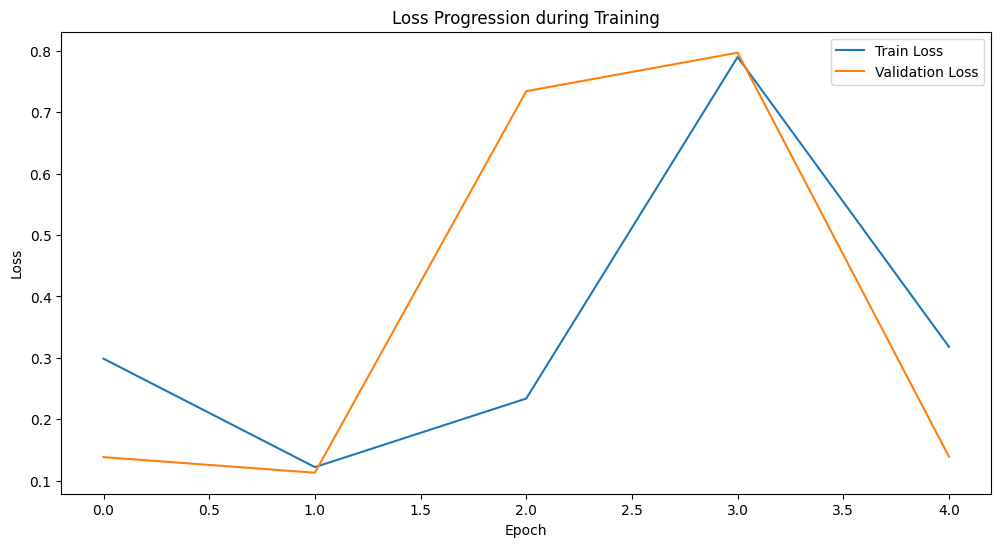

In [3]:
# Custom Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        #print(f"compute_loss: {return_outputs=}, {inputs.keys()=}")
        labels = inputs.pop("labels")
        soft_labels = inputs.pop("soft_labels")
        outputs = model(**inputs)
        logits = outputs.logits
        lsm = LogSoftmax(dim=1)
        loss_fct = KLDivLoss(reduction='batchmean')
        loss_soft = loss_fct(lsm(logits), soft_labels)
        loss_hard = CrossEntropyLoss()(logits, labels)
        loss = 0.5 * loss_soft + 0.5 * loss_hard
        return (loss, outputs) if return_outputs else loss

    def get_train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.args.train_batch_size)

    def get_eval_dataloader(self):
        #return DataLoader(eval_dataset if eval_dataset is not None else self.eval_dataset, batch_size=self.args.eval_batch_size)
        return DataLoader(self.eval_dataset, batch_size=self.args.eval_batch_size)

    #def get_test_dataloader(self, test_dataset):
    def get_test_dataloader(self):
        #return DataLoader(test_dataset, batch_size=self.args.eval_batch_size)
        return DataLoader(self.test_dataset, batch_size=self.args.test_batch_size)

# トレーニングの設定
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# トレーナーの初期化
trainer = CustomTrainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

optimizer = AdamW(student_model.parameters(), lr=1e-3)
trainer.optimizer = optimizer

# トレーニングの総ステップ数を定義
total_steps = len(trainer.get_train_dataloader()) * training_args.num_train_epochs

# ウォームアップステップ数を定義
warmup_steps = int(total_steps * 0.1)  # 例えば、総ステップ数の10%
print(f"{total_steps=}, {warmup_steps=}")

# スケジューラの作成
lr_scheduler = get_linear_schedule_with_warmup(
    trainer.optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
trainer.lr_scheduler = lr_scheduler

# 早期停止のためのパラメータ
early_stopping_patience = 3
best_val_loss = float('inf')
no_improvement_count = 0

# トレーニングの実行
train_loss = []
val_loss = []
for epoch in range(training_args.num_train_epochs):
    # トレーニング
    student_model.train()
    total_loss = 0
    for idx, batch in enumerate(trainer.get_train_dataloader()):
        loss = trainer.compute_loss(student_model, batch)
        total_loss += loss.item()
        loss.backward()
        trainer.optimizer.step()
        trainer.lr_scheduler.step()
        trainer.optimizer.zero_grad()
        if idx % 50 == 0:
            current_lr = trainer.optimizer.param_groups[0]['lr']
            print(f"train: batch num {idx=} done. {current_lr=}")
    avg_train_loss = total_loss / len(trainer.get_train_dataloader())
    train_loss.append(avg_train_loss)

    # バリデーション
    student_model.eval()
    total_loss = 0
    for batch in trainer.get_eval_dataloader():
        with torch.no_grad():
            loss = trainer.compute_loss(student_model, batch)
            total_loss += loss.item()
    avg_val_loss = total_loss / len(trainer.get_eval_dataloader())
    val_loss.append(avg_val_loss)

    # 早期停止のチェック
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print("Early stopping triggered")
        break

    print(f"train: {epoch=} done. {avg_train_loss=}, {avg_val_loss=}")

# 損失の推移を描画
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression during Training')
plt.legend()
plt.show()

# モデルの保存
student_model.save_pretrained("distilled_model")



In [4]:
# 評価（前のステップで作成した関数を再利用）
# ...
# 評価関数
def evaluate_model(model, dataset, batch_size=8):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    total, correct = 0, 0
    start_time = time.time()
    for batch in dataloader:
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(model.device)
        with torch.no_grad():
            soft_lables = inputs.pop("soft_labels")
            outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
    elapsed_time = time.time() - start_time
    return correct / total, elapsed_time

# 各データセットに対する評価
train_accuracy, train_time = evaluate_model(student_model, train_dataset)
val_accuracy, val_time = evaluate_model(student_model, val_dataset)
test_accuracy, test_time = evaluate_model(student_model, test_dataset)

print(f"Train Accuracy: {train_accuracy}, Time: {train_time}")
print(f"Validation Accuracy: {val_accuracy}, Time: {val_time}")
print(f"Test Accuracy: {test_accuracy}, Time: {test_time}")


Train Accuracy: 0.9741626794258373, Time: 25.594884872436523
Validation Accuracy: 0.9626436781609196, Time: 8.5161452293396
Test Accuracy: 0.9656160458452722, Time: 8.525270700454712
